In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Loading data, inform the name and path if necessary
filename = 'data_engineering_challenge_dataset[96].csv'
data = pd.read_csv(filename)

In [ ]:
### Step 1: Functions to parallel execution ###
# Functions definitions
def verify_schema(df):
    """
    Verify dataframe dtypes
    
    Parameters:
    df (pandas.DataFrame): DataFrame original
    """
    return df.dtypes

def verify_missing_values(df):
    """
    Verify number of missing values in dataframe
    
    Parameters:
    df (pandas.DataFrame): DataFrame original
    """
    return df.isnull().sum()

def verify_erros(df):
    """
    Verify number of negative values in dataframe.
    Add new validations if necessary
    
    Parameters:
    df (pandas.DataFrame): DataFrame original
    """
    # Count negative values for numeric columns
    negativos = df.select_dtypes(include=['int64', 'float64']).lt(0).sum()
    negativos = negativos[negativos > 0]
    return negativos


In [4]:
# Execute in parallel 
start_parallel = time.time()

with ThreadPoolExecutor() as executor:
    check_schema = executor.submit(verify_schema, data)
    check_missing_values = executor.submit(verify_missing_values, data)
    check_errors = executor.submit(verify_erros, data)

# Collecting results
schema_check = check_schema.result()
missing_values = check_missing_values.result()
errors = check_errors.result()

end_parallel = time.time()

print(f"\nTotal time for parallel execution: {end_parallel - start_parallel:.2f} seconds")


Total time for parallel execution: 0.00 seconds


In [5]:
# Parallel execution results
print("Data schema:\n", schema_check)
print("\nMissing values by column:\n", missing_values)
print("\nCheck errors negative values:\n", errors)

Data schema:
 loan_id                    int64
application_date          object
loan_amount              float64
interest_rate            float64
term_months                int64
loan_status               object
customer_income          float64
customer_credit_score      int64
employment_length         object
dtype: object

Missing values by column:
 loan_id                    0
application_date           0
loan_amount              198
interest_rate            150
term_months                0
loan_status                0
customer_income            0
customer_credit_score      0
employment_length          0
dtype: int64

Check errors negative values:
 customer_income          100
customer_credit_score     28
dtype: int64


In [6]:
### Step 2: Sequencial processing ###
# 2.1 Normalize a column - customer_income
data['customer_income_normalized'] = (data['customer_income'] - data['customer_income'].min()) / (data['customer_income'].max() - data['customer_income'].min())

# Apply date type to column
if schema_check['application_date'] == 'O':
    data['application_date'] = pd.to_datetime(
        data['application_date'],
        format='%Y-%m-%d',
        errors='coerce'
    )

# 2.2 Filter a column by a specific value ('loan_status' == 'Approved')
# Removed rows with negative value
data_clean = (
    data[(data['customer_income'] > 0) & (data['customer_credit_score'] > 0)]
    .dropna()
)
# Filter for categorigal value - Approved
approved_loans = data_clean[data_clean['loan_status'] == 'Approved']

# 2.3 Group certain columns (any that correspond to dates)
# Group by Year and status
data_clean['application_year'] = pd.to_datetime(data_clean['application_date']).dt.year
loans_by_year = data_clean.groupby(['application_year','loan_status']).size()
print("\nLoans by year and status:\n", loans_by_year)


Loans by year and status:
 application_year  loan_status
2023              Approved       136
                  Defaulted       32
                  Pending         79
                  Rejected        66
2024              Approved       157
                  Defaulted       39
                  Pending         74
                  Rejected        55
2025              Approved       166
                  Defaulted       32
                  Pending         64
                  Rejected        75
2026              Approved       136
                  Defaulted       30
                  Pending         66
                  Rejected        69
2027              Approved       160
                  Defaulted       28
                  Pending         66
                  Rejected        67
2028              Approved       174
                  Defaulted       37
                  Pending         67
                  Rejected        81
2029              Approved       165
                 

In [7]:
### Step 3: Sequencial processing ###
# 3.1 Transform a variable and add it to the dataset.(Apply the function x^3 + exp(y) on any continuous variable).
data_clean['loan_amount_transformed'] = data_clean['loan_amount'] ** 3 + np.exp(data_clean['interest_rate'])

# 3.2 Aggregation. Count unique records (on any categorical column).
unique_employment_counts = data_clean['employment_length'].nunique()
print("\nNumbers of unique 'employment_length':", unique_employment_counts)



Numbers of unique 'employment_length': 5


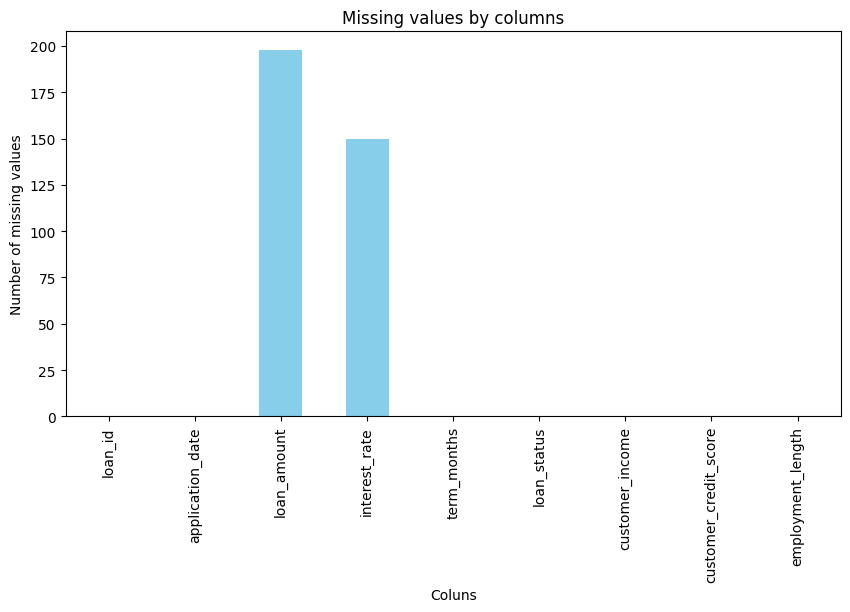

In [8]:
### Step 4: Vizualization ###
# 4.1 Missing values by columns
plt.figure(figsize=(10, 5))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing values by columns')
plt.xlabel('Coluns')
plt.ylabel('Number of missing values')
plt.show()

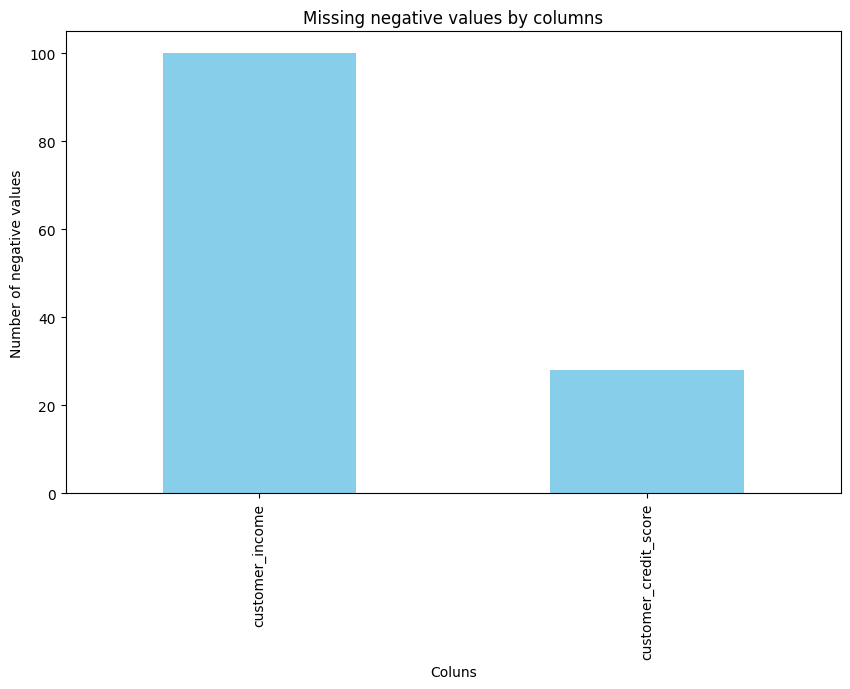

In [9]:
# 4.2 Number of negative values for numeric columns
# negative = data.select_dtypes(include=['int64', 'float64']).lt(0).sum()
# Criar o gráfico
plt.figure(figsize=(10, 6))
errors.plot(kind='bar', color='skyblue')
plt.title('Missing negative values by columns')
plt.xlabel('Coluns')
plt.ylabel('Number of negative values')
plt.show()

In [10]:
# 4.3 Tabela resumida de registros únicos
print("\nTabela de resumo dos dados:")
print(data[['loan_status', 'employment_length']].drop_duplicates().groupby('loan_status').size())


Tabela de resumo dos dados:
loan_status
Approved     5
Defaulted    5
Pending      5
Rejected     5
dtype: int64
